# Temporal and Spatial Variation in Stress Levels within a Population of Pikas

## Summary
This notebook is based on data collected by Ashley Whipple at the Niwot Ridge Long-term Ecological Research Program in Colorado, US. The full data set can be downloaded [here](https://search.dataone.org/view/https%3A%2F%2Fpasta.lternet.edu%2Fpackage%2Fmetadata%2Feml%2Fknb-lter-nwt%2F268%2F1). Over a course of three months in 2018, the researchers collected fecal specimens from 20 different Pika territories and analyzed them for their concentration of stress-associated hormone metabolites. In the accompanying [research article](https://academic.oup.com/conphys/article/9/1/coab024/6262596) [1], the authors explore the effect of habitat characteristics and seasonal variation on Pika stress levels and find that shared seasonal circumstances appear to have a higher impact on stress than differences in individual habitat quality.
In this notebook, I implement an analysis workflow in Python and R, following along with the paper's methods and findings, diverging at certain points to provide additional insights into the data.

**Skills**: **Python, R**; Data cleaning, Data transformation, Data analysis, Data visualization, Statistical Testing, Generalized Linear Models, Linear Mixed Effects Models.

## Background
The American Pika (Ochotona princeps) is a highly territorial, small mammal, home to rocky habitats in western North America [2]. These animals do not migrate or hibernate, but instead spend all of Spring and Summer gathering herbaceous vegetation in a hay pile which they feed on throughout winter [2, 3]. Pikas can not tolerate warm temperatures over 24C for extended amounts of time [4], and thus are threatened by the warming climate and the shift of their range to higher and higher elevations [5, 6]. While some studies have shown local extirpations and retractions [7], others suggest that Pikas may be able to adjust and persist under changing conditions [8]. Population declines can be a consequence of higher stress levels in individual animals. It is therefore important to understand which factors affect stress hormone levels in Pikas and thereby gain insights into potential interventions that could help protect this species. The authors of the study propose several different hypotheses for stress variation between hypothetical individuals (See figure below). In this notebook, we will explore the evidence for each of these hypotheses.

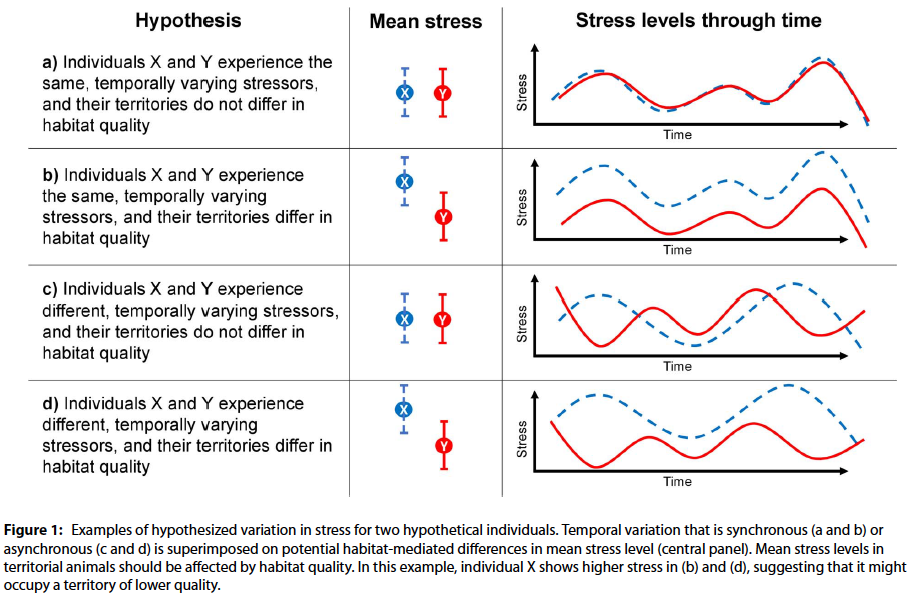

# Environment Setup
First, we set up the python environment and load all necessary packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

In [3]:
# # connect to google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # set current directory to portfolio folder
# os.chdir('/content/drive/MyDrive/Job search/portfolio')

In [4]:
sns.set_context('notebook')

# Load and Clean Data
In this section, we will load the study data into pandas data frames and explore the data structure, values, and distributions.

## Load data

First, let's **load in the study data**. The data are provided as two separate csv files:
* one file providing habitat information for each separate sampling site (20 unique stations)
* one file providing glucocorticoid metabolite (GCM) concentration for individual stations sampled at multiple time points

The authors found that fine scale environment conditions like ground cover types did not have an effect on stress levels in this study. For the sake of brevity and cleanliness of this notebook, we are therefore only loading a subset of relevant columns from the habitat quality data.

In [5]:
# load relevant columns for data on habitat quality
pika_habitat = pd.read_csv('data/pika_fecal_glut_habitat.aw.data.csv',
                           usecols=['Station','Temp_C','Largest_Rock_1st',
                                    'Largest_Rock_10th','Deepest_Crevice',
                                    'Aspect_Deg','Elev_M'])

# load relevant columns for data on GCM concentration per site and time point
pika_stress = pd.read_csv('data/pika_fecal_glut.aw.data.csv',
                          parse_dates=['Date'],
                          usecols=['Date','Station','Concentration_pg_g',
                                   'Plate','Site','Biweek','Sex'])

Let's take a closer look at what each dataset contains and how the data is structured in the next sections.

## Explore habitat data


**The metadata** provide the following attribute descriptions for the columns in this table:
* `Station`: Name of the sample station where feces were collected. Format: Site name (CG, WK, or LL) followed by a unique number.
* `Temp_C`: Temperature in celsius during survey
* `Largest_Rock_1st`: Length (in m) along longest axis of largest rock within 12 meters
* `Largest_Rock_10th`: Length (in m) along longest axis of 10th largest rock within 12 meters
* `Deepest_Crevice`: Depth class of deepest crevice within 12 meters (1: <0.5m, 2: >0.5 & <1m, 3: >1m & <1.5m, 4: >1.5m)
* `Aspect_Deg`: Aspect in degrees
* `Elev_M`: Elevation in meters

In [6]:
# take a look at first five rows
pika_habitat.head()

,Station,Temp_C,Largest_Rock_1st,Largest_Rock_10th,Deepest_Crevice,Aspect_Deg,Elev_M
0,CG1,60,2.0,1.5,2,203.657517,3343.246582
1,CG2,60,2.0,1.5,2,207.372604,3353.369629
2,CG3,60,2.0,1.5,1,192.834992,3357.718750
3,CG4,60,1.3,0.5,1,241.618576,3406.548096
4,LL1,60,3.0,2.0,1,313.318787,3295.538086


In [7]:
# check for missing values
pika_habitat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Station            20 non-null     object 
 1   Temp_C             20 non-null     int64  
 2   Largest_Rock_1st   20 non-null     float64
 3   Largest_Rock_10th  20 non-null     float64
 4   Deepest_Crevice    20 non-null     int64  
 5   Aspect_Deg         20 non-null     float64
 6   Elev_M             20 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.2+ KB


There are no missing values in this dataset.

In [8]:
pika_habitat.Station.nunique()

20

In [9]:
pika_habitat.Station.unique()

array(['CG1', 'CG2', 'CG3', 'CG4', 'LL1', 'LL2', 'LL3', 'WK1', 'WK10',
       'WK11', 'WK12', 'WK13', 'WK2', 'WK3', 'WK4', 'WK5', 'WK6', 'WK7',
       'WK8', 'WK9'], dtype=object)

There are 20 unique sampling stations (hay piles) contained in the data from three different sites (larger sampling areas). These stations are where the feces were collected for analysis. Under the assumptions of this study, the stations correspond to 20 different individual Pikas.

In [10]:
# get summary statistics for all numeric columns
pika_habitat.describe()

,Temp_C,Largest_Rock_1st,Largest_Rock_10th,Deepest_Crevice,Aspect_Deg,Elev_M
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,61.300000,1.352500,0.856500,1.550000,176.593925,3501.704614
std,2.341839,0.689866,0.520731,0.686333,103.836500,129.160074
min,58.000000,0.500000,0.300000,1.000000,5.911438,3278.479492
25%,60.000000,0.937500,0.500000,1.000000,103.277256,3356.631470
50%,60.000000,1.000000,0.500000,1.000000,164.588501,3579.382569
75%,63.500000,2.000000,1.500000,2.000000,259.543629,3601.819702
max,65.000000,3.000000,2.000000,3.000000,332.519806,3616.445557


Looking at the value distribution for the `Temp_C` column (ranging from 58 to 65), it looks like the information was actually recorded in Fahrenheit and not Celsius.

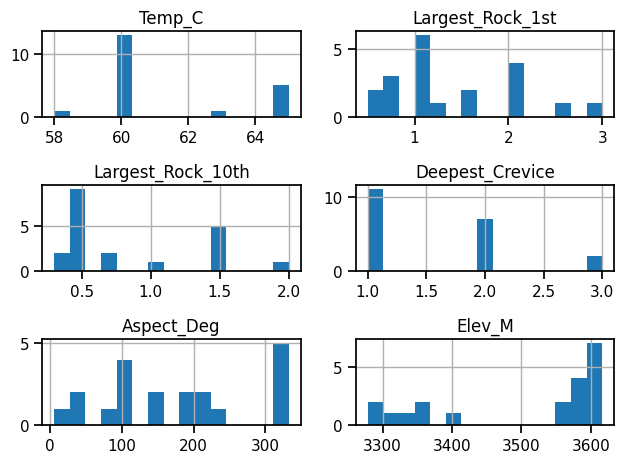

In [11]:
# plot a histograms for all numeric columns
pika_habitat.hist(bins=15)
plt.tight_layout()
plt.show()

Looks like there is a bimodal distribution of elevations in the data, with one group of samples collected around 3300-3400 meters and another group collected at an elevation of around 3600 meters. This aligns with the authors' descriptions of the three different sampling areas. They describe two sites (LL and CG) to be located below tree line, while the third site (WK) is located above tree line.

I am slightly confused as to why temperature was only collected once for each site, since it will change over time. Would have made more sense to me to measure temperature for each observation per site and time point. As it is, most sites seem to have a recorded temperature of 60 degrees Fahrenheit, so we are unlikely to directly determine any effects of ambient temperature on Pika stress level.

## Explore stress data

**The metadata** provide the following attribute descriptions for the columns in this table:
* `Station`: Name of the sample station where feces were collected. Format: Site name (CG, WK, or LL) followed by a unique number.
* `Date`: Date the sample was collected
* `Concentration_pg_g`: Glucocorticoid metabolite (GCM) concentration given as picogram/gram dry feces
* `Plate`: Unique identifier for the Corticosterone Enzyme Immunoassay plate that was used to evaluate the glucocorticoid concentration for the fecal sample (1-5)
* `Site`: Site name of where the sample station was located. Site names are CG (cable gate), WK (west knoll), or LL (long lake)
* `Biweek`: Date binned into 2-week sampling periods (1-7)
* `Sex`: Sex as determined by genetic analysis of the fecal sample. M (male), F (Female), or U (unknown - either from failure to determine sex through genetic analysis or inability to perform genetic analysis due to small sample size)

In [12]:
# take a look at first five rows
pika_stress.head()

,Date,Station,Concentration_pg_g,Plate,Site,Biweek,Sex
0,2018-06-08,CG1,11563.40758,1,CG,1,M
1,2018-06-08,CG2,10629.14328,1,CG,1,M
2,2018-06-08,CG3,10923.56761,1,CG,1,M
3,2018-06-13,WK3,10413.54461,1,WK,1,M
4,2018-06-13,WK4,13530.58929,1,WK,1,M


In [13]:
# check for missing values
pika_stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                109 non-null    datetime64[ns]
 1   Station             109 non-null    object        
 2   Concentration_pg_g  109 non-null    float64       
 3   Plate               109 non-null    int64         
 4   Site                109 non-null    object        
 5   Biweek              109 non-null    int64         
 6   Sex                 109 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.1+ KB


There are no missing values.

In [14]:
# get summary statistics for all numeric columns
pika_stress.describe()

,Date,Concentration_pg_g,Plate,Biweek
count,109,109.000000,109.000000,109.000000
mean,2018-07-29 08:35:13.761467904,5176.158825,3.055046,4.201835
min,2018-06-08 00:00:00,834.047140,1.000000,1.000000
25%,2018-07-11 00:00:00,2667.613850,2.000000,3.000000
50%,2018-07-31 00:00:00,4261.143434,3.000000,4.000000
75%,2018-08-20 00:00:00,7169.233683,4.000000,6.000000
max,2018-09-04 00:00:00,13530.589290,5.000000,7.000000
std,NaN,2975.655607,1.439102,1.869739


The fecal samples were collected between 06/08/2018 and 09/04/2018.

In [15]:
# count how many individuals of each sex were included in analysis
pika_stress.groupby('Sex')['Station'].nunique()

Sex
M    11
U     9
Name: Station, dtype: int64

The study included 11 individuals genetically identified as male, and 9 individuals for which the sex is unknown either due to failure to determine sex through genetic analysis or inability to perform genetic analysis due to small sample size.

In [16]:
# take a look at distributions of samples by site
nobs = pika_stress.groupby('Site')['Station'].agg(['nunique', 'count']).reset_index()
nobs.columns = ['Site','n_stations','n_observations']
nobs

,Site,n_stations,n_observations
0,CG,4,20
1,LL,3,9
2,WK,13,80


The sampling stations were not evenly distributed between the three sites. Site WK contributed 13 individuals to the study with 80 samples from those individuals over time. Site CG had four individuals and 20 total samples taken over time. Site LL had only 3 individuals with 9 samples taken total.

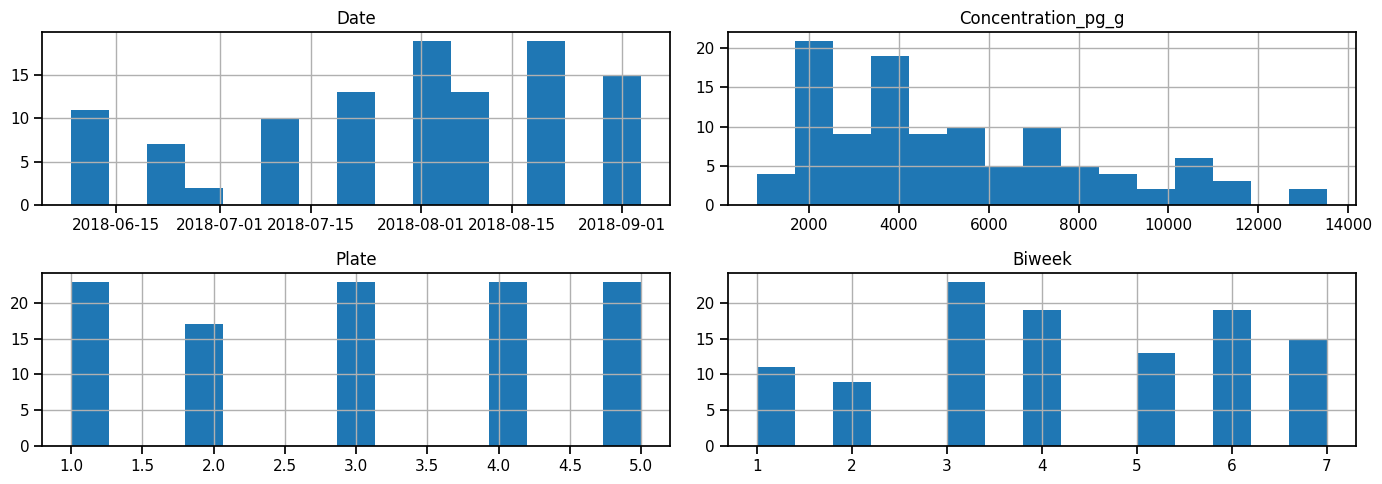

In [17]:
# plot histograms for all numeric columns
fig, ax = plt.subplots(2,2,figsize=(14,5))
pika_stress.hist(bins=15, ax=ax)
plt.tight_layout()
plt.show()

* The sample analysis was distributed fairly evenly across immunoassay plates.
* There were slightly more samples taken during August than during the rest of the study period.
* The distribution of GCM concentration values is slightly skewed towards lower concentrations. We might want to use a log transformation in order to get our output variable to be more normally distributed.

## Clean and Transform Data

Here are some things I noticed about the data which we might want to clean up a bit before analysis:

**split data into station information and time-dependent observations**

* Some constant variables (like Site and Sex, which was only determined once per individual) are contained in the table of observations for each time point. Ideally, I would like to create one dataframe containing all information that pertains to the stations and is constant over time and one data frame containing the observations with variables that change over time, like Date, GCM concentration, etc.

* `Station` will be the common key to connect both dataframes with each other.

**data transformation**

For any sort of regression modeling, it is important that all variables are on a similar scale and in the best case normally distributed. This ensures the fulfillment of necessary model assumptions and validity of results.
* The distribution of GCM concentrations is skewed towards smaller values and on a scale of thousands of pg/g. We should log transform this variable to gain a normal distribution and scale of values that is more similar to other variables.
* The aspect is given in degrees, ranging between 0 and 360 degrees. We will take the cosine of the aspect in degrees to bring the values to a scale between -1 and 1.
* We will use the `Date` column to compute a `DOY` column (Day of the year) and its z-score, in order to have a variable representing time, mean-centered and with a standard deviation of 1. We will also add a `DOY2` column with the squared values for day of year and it's z-score, to account for possible non-linear effects in time.
* We will also compute the z-score of the temperature and elevation, in order to bring them to the same scale as all other variables.
* We will transform `Sex` into a numeric variable, replacing 'M' with 1 and 'U' with 0.

In [18]:
# create new "static" dataframe with only variables that don't change over time (or were only measured once)
static1 = pika_habitat.copy()
static2 = pika_stress[['Station','Site','Sex']].drop_duplicates()
static = static1.merge(static2,on='Station',how='left')

# transform static variables to adjust scale
static['Temp_Z'] = zscore(static['Temp_C']) # z-transform temperature
static['Aspect_COS'] = np.cos(static['Aspect_Deg']) # cosine transform aspect
static['Elev_Z'] = zscore(static['Elev_M']) # z-transform elevation
static['Male'] = (static['Sex'] == 'M')*1 # male sex numeric variable

# keep only clean and relevant columns
static = static[['Station','Temp_Z','Aspect_COS','Elev_Z','Site','Male']]

# save clean static dataframe to csv file
static.to_csv('data/pika_static.csv',index=False,sep=',')

static.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     20 non-null     object 
 1   Temp_Z      20 non-null     float64
 2   Aspect_COS  20 non-null     float64
 3   Elev_Z      20 non-null     float64
 4   Site        20 non-null     object 
 5   Male        20 non-null     int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 1.1+ KB


In [19]:
# create new "observations" dataframe with variables that change over time
observations = pika_stress[['Date','Station','Concentration_pg_g','Plate','Biweek']].copy()

# transform observation variables to adjust scale
observations['GCM_LOG'] = np.log(observations['Concentration_pg_g']) # log transform concentration values to match scale and normal distribution
observations['DOY'] = pd.DatetimeIndex(observations['Date']).dayofyear # extract day of year (Julian) from the date column
observations['DOY_Z'] = zscore(observations['DOY']) # z-transform to match scale to other variables
observations['DOY2'] = observations['DOY']**2 # squared day of year to account for non-linearity
observations['DOY2_Z'] = zscore(observations['DOY2']) # z-transform to match scale to other variables

# keep only clean and relevant columns
observations = observations[['Date','DOY_Z','DOY2_Z','Biweek','Station','Plate','GCM_LOG']]

# save clean observations dataframe to csv file
observations.to_csv('data/pika_obs.csv',index=False,sep=',')

observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     109 non-null    datetime64[ns]
 1   DOY_Z    109 non-null    float64       
 2   DOY2_Z   109 non-null    float64       
 3   Biweek   109 non-null    int64         
 4   Station  109 non-null    object        
 5   Plate    109 non-null    int64         
 6   GCM_LOG  109 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 6.1+ KB


Lastly, we will create one **joined dataframe** of observations and static information merged together.

In [20]:
# load clean dataframes
static = pd.read_csv('data/pika_static.csv')
observations = pd.read_csv('data/pika_obs.csv')

# join dataframes on key `Station`
pika_data = observations.merge(static, on='Station', how='left')

# save clean joined dataframe
pika_data.to_csv('data/pika_data_clean.csv',index=False,sep=',')

# take a look
pika_data.head()

,Date,DOY_Z,DOY2_Z,Biweek,Station,Plate,GCM_LOG,Temp_Z,Aspect_COS,Elev_Z,Site,Male
0,2018-06-08,-2.013580,-1.868474,1,CG1,1,9.355601,-0.56954,-0.854605,-1.258706,CG,1
1,2018-06-08,-2.013580,-1.868474,1,CG2,1,9.271355,-0.56954,0.999622,-1.178294,CG,1
2,2018-06-08,-2.013580,-1.868474,1,CG3,1,9.298678,-0.56954,-0.364370,-1.143746,CG,1
3,2018-06-13,-1.817545,-1.714672,1,WK3,1,9.250863,-0.56954,0.974270,0.605962,WK,1
4,2018-06-13,-1.817545,-1.714672,1,WK4,1,9.512708,-0.56954,0.507226,0.655254,WK,1


# Exploratory Data Analysis

We'll load the cleaned data and explore a bit more to get an idea of how the variables relate to each other.

In [21]:
# load clean data
pika_data = pd.read_csv('data/pika_data_clean.csv',parse_dates=['Date'])

Let's look at a pairplot of all variables that might have an effect on stress levels and see if we observe any trends or patterns.

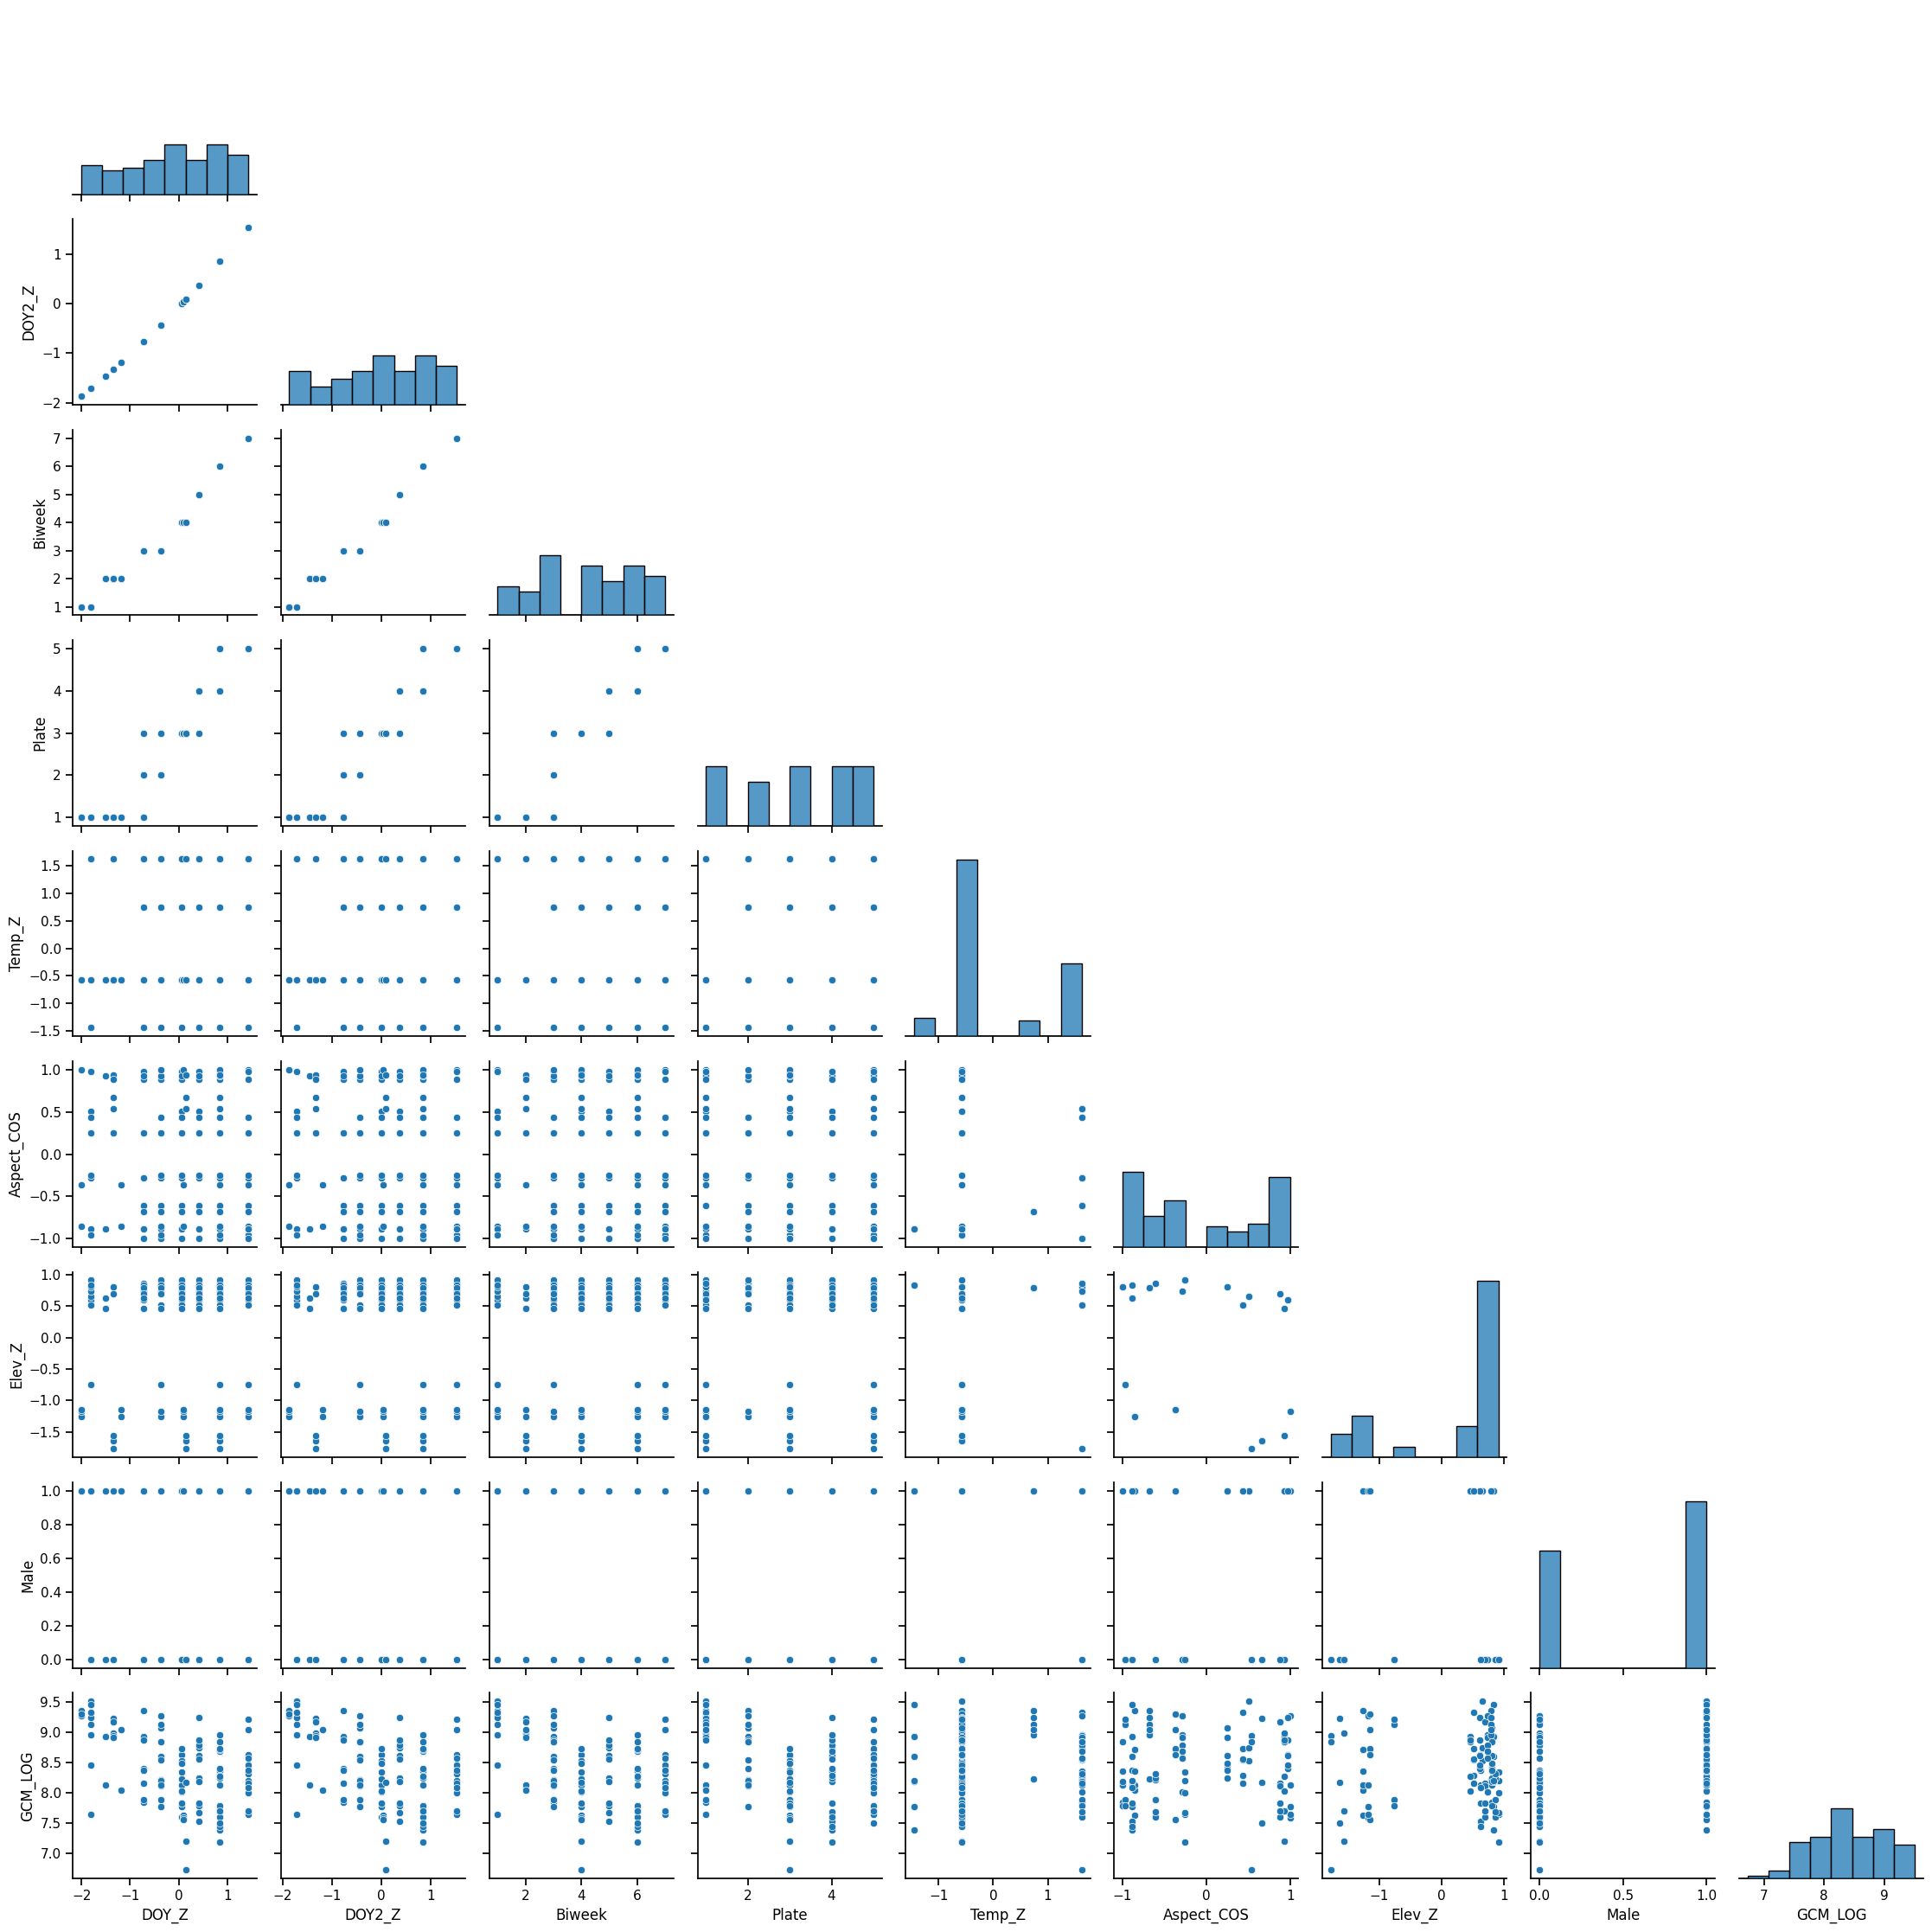

In [22]:
sns.pairplot(pika_data[['DOY_Z','DOY2_Z','Biweek','Plate','Temp_Z',
           'Aspect_COS','Elev_Z','Site','Male','GCM_LOG']], corner=True)
plt.tight_layout()
plt.show()

This pairplot gives us a first idea of whether any of the predictor variables are correlated with our outcome (the concentration of stress hormones `GCM_Log`) or with each other. It's important to identify predictor variables that are highly correlated in order to avoid multicollinearity. Multicollinearity can lead to inflated standard errors, unreliable coefficient estimates, and difficulties in determining the individual effect of each predictor.

From the pairplot, we can make the following observations about **variables and their correlation with GCM concentration**:
* There may be a non-linear correlation between GCM concentration and variables related to time of sampling, e.g., `DOY_Z`, `DOY2_Z`, `Biweek`, and interestingly, `Plate`
* There is no strong, visible correlation between GCM concentration and temperature or aspect
* There may be a weak correlation between GCM concentration and elevation, with higher elevations corresponding to slightly higher GCM concentrations.
* There also may be a weak correlation between GCM concentration and Male Sex, with the samples identified as coming from a male pika showing slightly higher stress levels.

Furthermore, we can see that some **variables are correlated with each other**:
* Naturally, day of year and its square counterpart are strongly correlated, but not linearly
* `Biweek` is also strongly correlated with `DOY_Z` since it's just a binning variable for sampling time grouped into two week chunks
* `Plate` seems to be also strongly linearly correlated with `DOY_Z`. This indicates that plates were filled up for analysis and evaluated chronologically, with higher plate numbers corresponding to later sampling times. This correlation between `DOY_Z` and the `Plate` variable could lead to confounding problems if we include both in a model.

**We should limit the time-related predictor variables in our model approach to `DOY_Z` and `DOY2_Z` to avoid multicollinearity.**


It does seem like stress concentrations change over time in our Pika population. Let's take a closer look at the data points over time in two different plots:
* one showing the GCM concentration in each individual over time, separated by sampling sites and colored by sex
* one showing GCM concentration across all pikas for each two week period

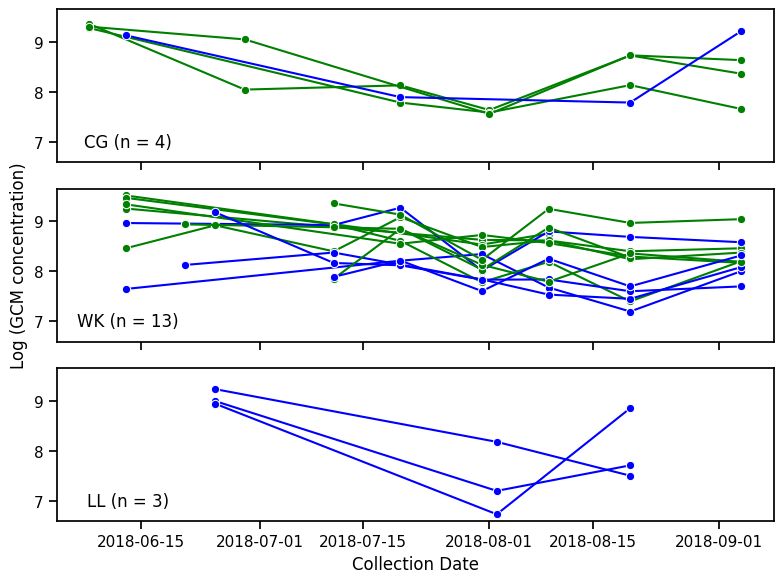

In [23]:
# make plots showing individual GCM concentrations by date separated into three sites

# set color palette for sex
sex_colors={1:'green',0:'blue'}

# create figure with 3 subplots
fig, axs = plt.subplots(3,1,figsize=(8,6),sharex=True, sharey=True)

# for each site, create one subplot
for i,site in enumerate(list(pika_data['Site'].unique())):
  data = pika_data[pika_data.Site == site]

  # for each station (individual) plot gcm concentration over time
  for station in list(data['Station'].unique()):
    sex_stat = data[data.Station == station]['Male'].unique()[0]
    sns.lineplot(data[data.Station == station], x='Date', y='GCM_LOG', ax=axs[i], markers=True, marker='o', color=sex_colors[sex_stat], estimator=None)
  axs[i].set_ylabel('')

  # add text providing number of individuals sampled at this site
  n_samples = str(len(list(data['Station'].unique())))
  axs[i].text(0.1, 0.1, f'{site} (n = {n_samples})',
              horizontalalignment='center', transform=axs[i].transAxes)

# set axis labels
axs[1].set_ylabel('Log (GCM concentration)')
axs[2].set_xlabel('Collection Date')

plt.tight_layout()
plt.show()


Plot showing boxplots of Log GCM concentrations for each biweek period (across all stations)

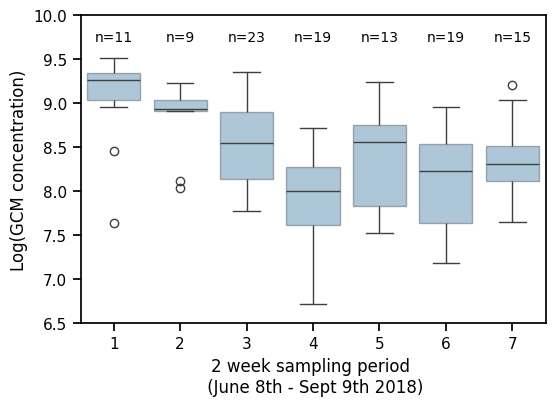

In [24]:
# make plots showing individual GCM concentrations by date separated into three sites

# create figure with 1 subplots
fig,axs = plt.subplots(1,1,figsize=(6,4))

# determine number of observations per Biweek period
nobs = pika_data['Biweek'].value_counts().sort_index(ascending=True).values
# make a string list with number of observations for plotting
nobs = ["n=" + str(x) for x in nobs.tolist()]
pos = range(len(nobs))

# boxplot for each Biweek period
sns.boxplot(pika_data, x='Biweek', y='GCM_LOG',ax=axs,
            boxprops={'alpha': 0.4})

# Add labels with number of observations per biweek period
for tick,label in zip(pos,axs.get_xticklabels()):
    axs.text(pos[tick],
            9.7,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='k')

# configure axes and labels
axs.set_ylim(6.5,10)
axs.set_ylabel('Log(GCM concentration)')
axs.set_xlabel(f'2 week sampling period \n (June 8th - Sept 9th 2018)')

plt.show()

Looking at the GCM concentrations over time, we observe a slightly U-shaped pattern, with stress levels at a minimum during sampling period 4 (around the beginning of August). This indicates a nonlinear relationship between time and GCM concentrations.


# Generalized Linear Model to test static predictor variables

I am interested in exploring the effect of the static predictor variables on the outcome using a generalized linear model. This modeling approach is not suited for the case of having multiple observations per Pika individual, which is why we will switch to using Linear Mixed Models in the final modeling step to include time in our predictor variables.

For now, I want to get an idea of how much the static variables like elevation and sex influence stress if it was constant over time. To this end, we will average the log GCM concentration for each pika individual over time, resulting in one average value per individual. Then, we will fit a generalized linear model (OLS regression) to determine which static variables have a significant effect on the outcome.

Let's start by creating a dataframe that contains the average Log(GCM) concentration over time for each Pika individual (each station) and all of the static predictor variables, which are sampling site/station specific.

In [25]:
# load clean dataframes
static = pd.read_csv('data/pika_static.csv')
observations = pd.read_csv('data/pika_obs.csv')

# get average GCM concentration over time for each Pika individual
station_avg = observations.groupby('Station')['GCM_LOG'].mean().reset_index()
station_avg.columns = ['Station','AVG_GCM_LOG']

# merge static spatial variables to this station average dataframe
station_avg = station_avg.merge(static, on='Station')
station_avg.head()

,Station,AVG_GCM_LOG,Temp_Z,Aspect_COS,Elev_Z,Site,Male
0,CG1,8.371531,-0.56954,-0.854605,-1.258706,CG,1
1,CG2,8.082357,-0.56954,0.999622,-1.178294,CG,1
2,CG3,8.649732,-0.56954,-0.364370,-1.143746,CG,1
3,CG4,8.500847,-0.56954,-0.959926,-0.755872,CG,0
4,LL1,8.301361,-0.56954,0.667106,-1.637676,LL,0


Now we can fit the GLM and look at the estimated coefficients and p values for each predictor variable.

In [27]:
# GLM with AVG_GCM_LOG as outcome variable, and all static site characteristics as predictor variables

# choose distribution family for outcome variable (in our case, normal with identity link)
family = sm.families.Gaussian(sm.families.links.Identity())

# assign data
data = station_avg.copy()

# build regression formula
formula = 'AVG_GCM_LOG ~ Temp_Z + Aspect_COS + Elev_Z + Site + Male'

# fit model
model = smf.glm(formula=formula, data=data, family=family).fit()

# print results summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            AVG_GCM_LOG   No. Observations:                   20
Model:                            GLM   Df Residuals:                       13
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                         0.11167
Method:                          IRLS   Log-Likelihood:                -2.1487
Date:                Wed, 05 Feb 2025   Deviance:                       1.4517
Time:                        13:02:37   Pearson chi2:                     1.45
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3638
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3999      0.758     11.089      0.0

Male sex (as opposed to unknown in this case) has a statistically significant (p < 0.05) effect on time-averaged stress levels. The inferred coefficient is positive, indicating higher stress levels in male individuals.

Let's take a look at a boxplot comparing stress levels in the two sex categories.

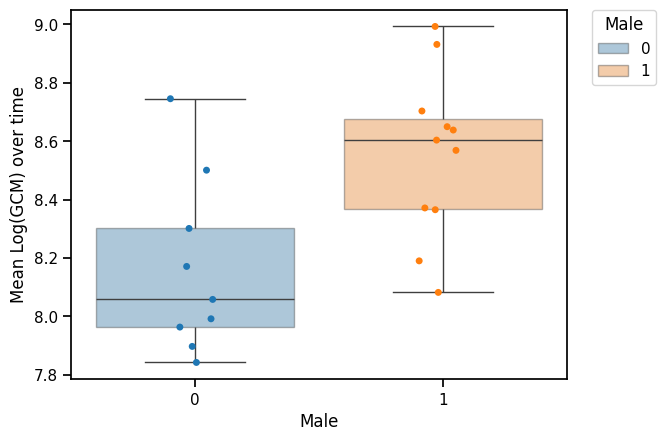

In [28]:
# make a boxplot comparing avg gcm concentrations between male and unknown sex

# figure with one plot
fig, ax = plt.subplots(1,1)

# boxplot and strip plot to show individual data points (one per pika)
sns.boxplot(data=station_avg, x='Male', hue='Male', y='AVG_GCM_LOG',ax=ax, boxprops={'alpha': 0.4})
sns.stripplot(data=station_avg, x='Male', y='AVG_GCM_LOG', hue='Male', ax=ax, legend=False)

# set y axis label
ax.set_ylabel('Mean Log(GCM) over time')
# configure legend position and title
plt.legend(title='Male',bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


plt.show()

The visual agrees with the generalized linear model results above. Male individuals in this study appear to exhibit higher GCM concentrations than those individuals with unknown sex.

# Linear Mixed Effects Models

## install R packages

In [30]:
import rpy2.robjects as ro
%load_ext rpy2.ipython

In [31]:
%%R
library(lme4)
library(AICcmodavg)

Loading required package: Matrix

Attaching package: ‘AICcmodavg’

The following object is masked from ‘package:lme4’:

    checkConv

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/local/lib/R/4.4/site-library’ contains no packages


## Testing candidate LME models

To characterize the spatial and temporal variation in stress levels, we will fit a set of candidate linear mixed effect models and rank them based on the Aikaike Information Criterium adjusted for small sample size 'AICc'.

Using Linear Mixed Effect models allows us to account for random effects due to inter-individual variability and weather by adding `Station` and `Date` as random effects to each model. In addition to the random effects, each candidate model will contain a number of fixed effects accounting for temporal and static variables and their interactions. Below, we explain the reasoning behind different model components:

* `DOY_Z`, `DOY2_Z`: capture any linear trends and any seasonal peak or
trough (nonlinearity) in GCM concentration
* `Male`: capture effect of sex on GCM concentration
* `Elev_Z`, `Aspect_COS`, `Site`: capture broad-scale habitat characteristics potentially affecting stress levels in nearby locations
* `DOY2_Z:Elev_Z`, `DOY2_Z:Site` : interaction terms to capture how elevation or site qualities may affect the timing of maximum and/or minimum GCM concentration


We switch to the R programming language to implement the linear mixed effect models. The python implementation of linear mixed effect models is lacking when it comes to including more than one random effect, so we will go with the established and most frequently used R implementation using the `lme4` package. This will also allow me to demonstrate my coding abilities in R.

In [32]:
%%R

# make a vector containing all candidate model formulas to loop through

formulas <- c(
    'GCM_LOG ~ DOY_Z + DOY2_Z + (1|Station) + (1|Date)',
    'GCM_LOG ~ DOY_Z + DOY2_Z + Male + (1|Station) + (1|Date)',
    'GCM_LOG ~ DOY_Z + DOY2_Z + Elev_Z + (1|Station) + (1|Date)',
    'GCM_LOG ~ DOY_Z + DOY2_Z + Male + Elev_Z + (1|Station) + (1|Date)',
    'GCM_LOG ~ DOY2_Z + Elev_Z + DOY2_Z:Elev_Z + (1|Station) + (1|Date)',
    'GCM_LOG ~ DOY_Z + DOY2_Z + Aspect_COS + (1|Station) + (1|Date)',
    'GCM_LOG ~ DOY_Z + DOY2_Z + Male + Aspect_COS + (1|Station) + (1|Date)',
    'GCM_LOG ~ DOY2_Z + Site + DOY2_Z:Site + (1|Station) + (1|Date)',
    'GCM_LOG ~ DOY_Z + DOY2_Z + Male + Site + (1|Station) + (1|Date)'
)

In [34]:
%%R
# load in csv with pika stress data and variables, prepared in python
data_pika <- read.csv('data/pika_data_clean.csv', sep=',')

# create empty vector to save AICc metrics for each candidate model
list_aicc <- c()

# loop through candidate formulas
for(form in formulas)
  {
    # fit lmer model for each candidate
    model <- lmer(form, data=data_pika)
    # compute AICc metric
    aicc <- AICc(model, return.K = FALSE, second.ord = TRUE, nobs = NULL)
    # append AICc for each candidate to previously created vector
    list_aicc <- append(list_aicc, aicc)
  }

# create dataframe with two columns from candidate formulas and corresponding
# AICc values
df <- data.frame(formulas,list_aicc)
colnames(df) <- c('Candidate_Formulas', 'AICc')

# save result dataframe
write.csv(df, 'results/pika_models_AICc.csv', row.names = FALSE)

## LME Results (based on model fit)
Let's inspect the results in order of increasing AICc, with lowest AICc representing the model which best fits the data.

In [35]:
# back to python to display results
results = pd.read_csv('results/pika_models_AICc.csv')
display(results.sort_values('AICc',ascending=True))

,Candidate_Formulas,AICc
1,GCM_LOG ~ DOY_Z + DOY2_Z + Male + (1|Station) ...,159.399612
0,GCM_LOG ~ DOY_Z + DOY2_Z + (1|Station) + (1|Date),161.252029
6,GCM_LOG ~ DOY_Z + DOY2_Z + Male + Aspect_COS +...,164.667869
3,GCM_LOG ~ DOY_Z + DOY2_Z + Male + Elev_Z + (1|...,164.850335
8,GCM_LOG ~ DOY_Z + DOY2_Z + Male + Site + (1|St...,166.010185
2,GCM_LOG ~ DOY_Z + DOY2_Z + Elev_Z + (1|Station...,166.178628
5,GCM_LOG ~ DOY_Z + DOY2_Z + Aspect_COS + (1|Sta...,166.181275
4,GCM_LOG ~ DOY2_Z + Elev_Z + DOY2_Z:Elev_Z + (1...,178.210132
7,GCM_LOG ~ DOY2_Z + Site + DOY2_Z:Site + (1|Sta...,180.463465


The model candidate with the most support uses the formula

`GCM_LOG ~ DOY_Z + DOY2_Z + Male + (1|Station) + (1|Date)`

with Station and Date as random effects and Day of Year (linear and nonlinear) and Sex as fixed effects. The second best model includes only the Day of Year variables as fixed effects. All other models including more habitat specific predictive variables appear to perform much worse with a difference in AICc to the top model of at least 5.

Let's take a look at the summary for the top model fit to inspect the coefficients for each predictor variable.

In [36]:
%%R

top_form = 'GCM_LOG ~ DOY_Z + DOY2_Z + Male + (1|Station) + (1|Date)'
# fit lmer model for top candidate
model <- lmer(top_form, data=data_pika)

summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: GCM_LOG ~ DOY_Z + DOY2_Z + Male + (1 | Station) + (1 | Date)
   Data: data_pika

REML criterion at convergence: 144.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.25670 -0.56448  0.07776  0.60233  2.42572 

Random effects:
 Groups   Name        Variance Std.Dev.
 Station  (Intercept) 0.05681  0.2384  
 Date     (Intercept) 0.07386  0.2718  
 Residual             0.15102  0.3886  
Number of obs: 109, groups:  Station, 20; Date, 13

Fixed effects:
            Estimate Std. Error t value
(Intercept)   8.1175     0.1323  61.344
DOY_Z        -3.3391     1.3490  -2.475
DOY2_Z        3.0915     1.3751   2.248
Male          0.3617     0.1361   2.658

Correlation of Fixed Effects:
       (Intr) DOY_Z  DOY2_Z
DOY_Z  -0.037              
DOY2_Z  0.050 -0.998       
Male   -0.583  0.035 -0.034


The linear term `DOY_Z` has a negative estimated coefficient, while the quadratic term `DOY2_Z` and `Male` sex have positive coefficients, indicating higher stress levels associated with higher squared day of year and with male sex. This is in line with the observations we made about a u-shaped correlation between time and GCM concentrations during the exploratory analysis and the findings from the generalized linear model, identifying that time-averaged GCM concentrations are significantly higher in individuals with male sex.

# Conclusion

Overall, we found that stress metabolite levels in Pikas are mainly influenced by season and by sex in this study. There was no support for broad-scale and fine-scale (not analyzed here but in the acompanying study) habitat quality influencing stress levels in this study. These results indicate that pikas in the sampled area share common temporally varying stressors without substantial differences in habitat quality. Looking back at the schema in Fig. 1, this corresponds to hypothesis a: individuals experience the same, temporally varying stressors and their territories do not differ in habitat quality.

In the accompanying manuscript, the authors argue that habitat features may have been too similar across sampled territories to observe effects of habitat quality on stress levels. For example, all stations were located at elevations without permafrost occurrence - not allowing for the testing of previous findings that the presence of ice under rocks near pika territories is strongly correlated with pika stress and persistence (Millar and Westfall, 2010; Erb et al., 2011).

The authors hypothesize that abiotic factors like sub-talus temperature and biotic factors related to reproductive cycles and food availability could be responsible for the observed seasonal variation in stress levels across territories. In particular, they point out that pikas might be more stressed around the time of a new litter (beginning of sampling period), and when they have to defend their territories against dispersing juveniles (end of sampling period). At the beginning of the sampling period in June, winter haypiles are depleted, leading to higher stress levels. After amassing haypiles over the summer, stress may increase again in the fall when the pikas have to defend their piles against competitors.

It is difficult to make a statement about the effect of male sex on GCM concentrations since we don't know whether the samples of unknown sex are female. While we found this variable to significantly contribute to stress level variability among territories, we therefore can not draw any final conclusions about sex differences in stress levels.

The dataset collected in this study is fairly small, sampling is unevenly distributed across sites, and the included sites exhibit very similar habitat characteristics. Hence, more studies should be conducted in more heterogeneous landscapes, with direct temperature sampling over time, to conclusively determine whether broad-scale or fine-scale habitat quality can affect stress metabolite levels in the American Pika.

# References



1.   Whipple AL, Ray C, Wasser M, Kitchens JN, Hove AA, Varner J, & Wilkening  JL (2020). Temporal vs. spatial variation in stress-associated metabolites within a population of climate-sensitive small mammals. Conservation Physiology, 9(1).
2.   Smith AT, Weston ML (1990) Ochotona princeps. Mamm Species 352: 1-8.
3.   Huntly NJ, Smith AT, Ivins BL (1986) Foraging behavior of the pika
(Ochotona princeps), with comparisons of grazing versus haying. J
Mammal 67: 139-148.
4.   MacArthur RA, Wang LCH (1974) Behavioral thermoregulation in the
pika Ochotona princeps: a field study using radiotelemetry. Can J Zool
52: 353-358.
5.   Beever EA, Ray C, Mote PW, Wilkening JL (2010) Testing alternative models of climate-mediated extirpations. Ecol Appl 20: 164-178.
6.   Beever EA, Ray C, Wilkening JL, Brussard PF, Mote PW (2011)
Contemporary climate change alters the pace and drivers of
extinction. Glob Chang Biol 17: 2054-2070.
7.   Galbreath KE, Hafner DJ, Zamudio KR (2009) When cold is
better: climate-driven elevation shifts yield complex patterns
of diversification and demography in an alpine specialist
(American pika, Ochotona princeps). Evolution 63: 2848-2863.
8.   Schwalm D, Epps CW, Rodhouse TJ, Monahan WB, Castillo JA, Ray C, Jeffress MR (2016) Habitat availability and gene flow influence diverging
local population trajectories under scenarios of climate change: a
place-based approach. Glob Chang Biol 22: 1572-1584.







